# How to visualize the trace of a neuron

This tutorial showcases how to pull a segment from S3 via CloudVolume, fit its trace with brainlit's `fit_spline` module, and visualize it. Here, we will pull segments from [s3://open-neurodata/brainlit/brain1_segments](s3://open-neurodata/brainlit/brain1_segments).

Downloading: 100%|██████████| 1/1 [00:00<00:00, 16.29it/s]
Found 77 branches in segment 161


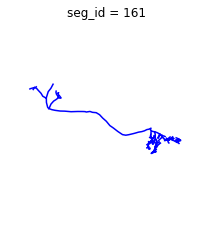

In [1]:
import numpy as np
import brainlit
from brainlit.algorithms.trace_analysis.fit_spline import GeometricGraph
from brainlit.utils.swc import read_s3, df_to_geometric_graph
from scipy.interpolate import BSpline, splev
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 8))

s3_path = "s3://open-neurodata/brainlit/brain1_segments"
mip = 0
# seg_ids = [161, 111, 2, 235, 83, 35, 7, 99]
seg_ids = [161]

for i, seg_id in enumerate(seg_ids):
    ax = fig.add_subplot(2, 4, i+1, projection="3d")
    df_neuron = read_s3(s3_path, seg_id, mip)
    dx = np.expand_dims(np.diff(df_neuron["x"].to_numpy()), axis=0).T
    dy = np.expand_dims(np.diff(df_neuron["y"].to_numpy()), axis=0).T
    dz = np.expand_dims(np.diff(df_neuron["z"].to_numpy()), axis=0).T
    dr = np.concatenate((dx, dy, dz), axis=1)
    assert all([any(du != 0) for du in dr])
    g_neuron = df_to_geometric_graph(df_neuron)
    spline_tree = g_neuron.fit_spline_tree_invariant()
    splines_L = len(spline_tree.nodes)
    print("Found {} branches in segment {}".format(splines_L, seg_id))

    for node in spline_tree.nodes:
        branch = spline_tree.nodes[node]
        tck, u = branch["spline"]
        t = tck[0]
        c = tck[1]
        k = tck[2]
        n_dim = len(c)
        L = len(u)
        trace = np.zeros((n_dim, L))
        for j, dim in enumerate(c):
            spl = BSpline(t, dim, k)
            trace[j, :] = spl(u)
        ax.plot(trace[0, :], trace[1, :], trace[2, :], "b-")

    # Hide axes ticks
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.axis('off')

    ax.set_title("seg_id = %d" % seg_id)

In [2]:
from cloudvolume import CloudVolume, Skeleton
from io import StringIO
import pandas as pd
import brainlit.utils.swc as swc
import matplotlib.pyplot as plt
import numpy as np

url_seg = "file:///Users/jacopo/JHU/NDD/repo/fork-brainlit/data/test_upload_segments"

# check input
cv = CloudVolume(url_seg, mip=0)
skeleton = cv.skeleton.get(2)
swc_string = skeleton.to_swc()
string_io = StringIO(swc_string)
splitted_string = swc_string.split("\n")
in_h = True
h_len = -1
while in_h:
    h_len += 1
    line = splitted_string[h_len]
    if len(line) == 0 or line[0] != "#":
        in_h = False
df = pd.read_table(
    string_io,
    names=["sample", "structure", "x", "y", "z", "r", "parent"],
    skiprows=h_len,
    sep=" "
    # delim_whitespace=True,
)

df_s3 = swc.read_s3(url_seg, seg_id=2, mip=0)

Downloading: 100%|██████████| 1/1 [00:00<00:00, 829.24it/s]


1650
1650


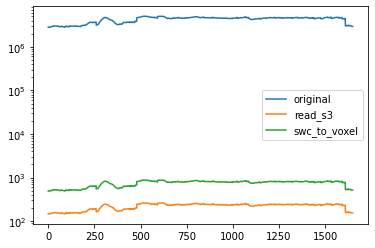

In [5]:
print(len(df["x"]))
print(len(df_s3["x"]))
plt.plot(df["x"], label="original")
plt.plot(df_s3["x"], label="read_s3")
plt.yscale("log")

spacing = np.array([0.29875923, 0.3044159, 0.98840415])
df_voxel_s3 = swc.swc_to_voxel(df_s3, spacing=spacing, origin=np.array([0, 0, 0]))
plt.plot(df_voxel_s3["x"], label="swc_to_voxel")
plt.legend()

In [4]:
# check original df
print(df["x"][0])
dx = np.expand_dims(np.diff(df["x"].to_numpy()), axis=0).T
dy = np.expand_dims(np.diff(df["y"].to_numpy()), axis=0).T
dz = np.expand_dims(np.diff(df["z"].to_numpy()), axis=0).T
dr = np.concatenate((dx, dy, dz), axis=1)
assert all([any(du != 0) for du in dr])

# check df_s3
print(df_s3["x"][0])
dx = np.expand_dims(np.diff(df_s3["x"].to_numpy()), axis=0).T
dy = np.expand_dims(np.diff(df_s3["y"].to_numpy()), axis=0).T
dz = np.expand_dims(np.diff(df_s3["z"].to_numpy()), axis=0).T
dr = np.concatenate((dx, dy, dz), axis=1)
assert all([any(du != 0) for du in dr])

2818200.75
147.0


AssertionError: 